In [13]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np

from tqdm import tqdm 
from geopy.geocoders import Nominatim

import os 
from glob import glob
import warnings
warnings.filterwarnings('ignore')

In [367]:
train_path = '../train.csv'
test_path  = '../test.csv'
bus_feature_path = '../bus_feature.csv'
subway_feature_path = '../subway_feature.csv'

df_train = pd.read_csv(train_path)
df_bus = pd.read_csv(bus_feature_path)
df_subway = pd.read_csv(subway_feature_path)
df_test = pd.read_csv(test_path)

/tmp/ipykernel_185360/1201119414.py:6: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_path)


In [368]:
# 시군으로 나누기
df_train['시군'] = df_train['시군구'].str.split().str[:2].apply(lambda x: ' '.join(x))

# 도로명 데이터를 이용하여 도로명주소 생성
df_train['주소'] = df_train['시군구'] + ' ' + df_train['번지']
df_train['도로명주소'] = df_train['시군'] + ' ' + df_train['도로명']

# 번지 주소가 없다면 도로명 주소로 채워줌, 번지 주소는 loc을 위함 
df_train.loc[df_train['주소'].isna(), '주소'] = df_train.loc[df_train['주소'].isna(), '시군'] + ' ' + df_train.loc[df_train['주소'].isna(), '도로명']

# 도로명의 값이 ' '인 값들을 찾아서 넣어줌
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 성동구 하왕십리동 1071'), '도로명주소'] = '서울특별시 성동구 난계로 100'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 중구 만리동2가 288'), '도로명주소'] = '서울특별시 중구 만리재로 177'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 성북구 돈암동 13-85'), '도로명주소'] = '서울특별시 성북구 돈암동 동소문로34길 73'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 마포구 아현동 372-29'), '도로명주소'] = '서울특별시 마포구 마포대로24길 16'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 송파구 송파동 167'), '도로명주소'] = ' 서울특별시 송파구 오금로32길 31'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 송파구 거여동 696'), '도로명주소'] = '서울특별시 송파구 오금로 551'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 강남구 역삼동 762'), '도로명주소'] = '서울특별시 강남구 도곡로43길 21'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 서초구 반포동 30-2'), '도로명주소'] = '서울특별시 서초구 고무래로 35'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 종로구 옥인동 179-3'), '도로명주소'] = '서울 종로구 옥인길 82'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 강남구 역삼동 763'), '도로명주소'] = '서울 강남구 도곡로43길 20'
df_train.loc[(df_train['도로명'] == ' ') & (df_train['주소'] == '서울특별시 서초구 서초동 1686-4'), '도로명주소'] = '서울 서초구 서초중앙로24길 33'

# 같은 주소이지만 도로명 값이 없는경우 다른 도로명주소가 생겨서 같은 도로명주소로 채워줌 
df_train['도로명주소'] = df_train.groupby('주소')['도로명주소'].transform('first')
df_train['주소'].isna().sum()

0

In [369]:
display(df_train[df_train['주소'] == '서울특별시 용산구 한강로2가 196']) # 1113986
display(df_train[df_train['주소'] == '서울특별시 마포구 토정동 2-4']) # 1050833

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,시군,주소,도로명주소
1113986,서울특별시 용산구 한강로2가,196,196.0,0.0,신용산빌딩,67.53,200701,17,3,1984,...,NaN,NaN,NaN,NaN,NaN,NaN,42750,서울특별시 용산구,서울특별시 용산구 한강로2가 196,서울특별시 용산구


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,시군,주소,도로명주소
1050833,서울특별시 마포구 토정동,2-4,2.0,4.0,마포지구시범6동,39.67,200710,9,6,1970,...,NaN,NaN,NaN,NaN,NaN,NaN,15400,서울특별시 마포구,서울특별시 마포구 토정동 2-4,서울특별시 마포구


In [370]:
# 데이터의 개수가 1개이고 없는 정보가 많아 삭제
df_train.drop([1050833, 1113986], inplace=True)

In [121]:
df_apt = pd.read_csv('../seoul_apt_info.csv', encoding='cp949')
df_apt.rename({'kapt도로명주소' : '도로명주소'}, axis=1, inplace=True)
df_apt

,번호,k-아파트코드,k-아파트명,"k-단지분류(아파트,주상복합등등)",도로명주소,주소(시도)k-apt주소split,주소(시군구),주소(읍면동),나머지주소,주소(도로명),...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,1,A15679103,우리유앤미,아파트,서울특별시 동작구 서달로 83,서울,동작구,흑석동,우리유앤미아파트,서달로,...,위탁,1773.56,223.0,의무,2018-04-10 15:59:42.0,Y,N,126.9596386,37.500668,2013-03-07 09:46:59.0
1,2,A13876112,송파파인타운13단지,아파트,서울특별시 송파구 송파대로8길 10,서울,송파구,장지동,857,송파대로8길,...,위탁,0.00,225.0,의무,2013-06-17 19:03:30.0,Y,N,127.1291789,37.476897,2013-03-07 09:46:59.0
2,3,A13873701,오금현대백조(임대),아파트,서울특별시 송파구 양재대로72길 20,서울,송파구,오금동,20-2,양재대로72길,...,위탁,6892.79,60.0,임의,2013-11-21 16:43:07.0,Y,N,127.1287745,37.508906,2013-03-07 09:46:59.0
3,4,A15275101,개봉건영,아파트,서울특별시 구로구 고척로21나길 85-6,서울,구로구,개봉동,47-1,고척로21나길,...,위탁,0.00,0.0,의무,2013-06-23 11:30:23.0,Y,N,126.8406749,37.501162,2013-03-07 09:46:59.0
4,6,A13991016,월계동원베네스트,아파트,서울특별시 노원구 월계로53길 21,서울,노원구,월계동,서울시 노원구 월계2동 940번지,월계로53길,...,위탁,0.00,206.0,의무,2015-06-19 09:59:49.0,Y,N,127.0582196,37.631732,2013-03-07 09:46:59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,40370,A10023020,삼성동 마에스트로,NaN,서울특별시 강남구 선릉로94길 15,서울,강남구,삼성동,NaN,선릉로94길,...,직영,944.63,112.0,임대,2023-12-26 17:45:39.0,Y,N,127.0497315,37.506280,2023-12-26 16:56:59.0
2767,40379,A10022941,마포푸르지오더센트럴,NaN,서울특별시 마포구 마포대로 231,서울,마포구,아현동,NaN,마포대로,...,위탁+직영,1908.76,225.0,의무,2023-11-27 09:04:41.0,Y,N,126.9564486,37.554546,2023-11-27 08:41:47.0
2768,40380,A10022928,강서금호어울림퍼스티어,아파트,서울특별시 강서구 화곡로54길 43,서울,강서구,화곡동,NaN,화곡로54길,...,위탁,4693.06,636.0,의무,2023-12-07 18:13:41.0,Y,N,126.8510647,37.550706,2023-12-07 17:14:49.0
2769,40386,A10022851,힐스테이트리슈빌강일,아파트,서울특별시 강동구 아리수로93다길 80,서울,강동구,강일동,NaN,아리수로93다길,...,위탁,15486.00,1086.0,의무,2024-01-11 13:47:18.0,Y,N,127.1748062,37.573716,2024-01-11 13:34:05.0


In [122]:
df_apt.columns

Index(['번호', 'k-아파트코드', 'k-아파트명', 'k-단지분류(아파트,주상복합등등)', '도로명주소',
       '주소(시도)k-apt주소split', '주소(시군구)', '주소(읍면동)', '나머지주소', '주소(도로명)',
       '주소(도로상세주소)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', '단지첨부파일',
       'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수',
       'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적',
       'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
       'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일'],
      dtype='object')

# geopy라이브러리를 이용해 도로명주소로 위도 경도 구하기 (좌표X, 좌표Y 채우기)

In [4]:
geo_local = Nominatim(user_agent='South Korea')

def geocoding(address):
    try:
        geo = geo_local.geocode(address)
        if geo:
            return geo.longitude, geo.latitude
        else:
            return np.nan, np.nan
    except:
        return np.nan, np.nan

In [7]:
address = df_train['주소'].drop_duplicates()
address

0           서울특별시 강남구 개포동 658-1
12            서울특별시 강남구 개포동 652
25           서울특별시 강남구 개포동 12-2
38            서울특별시 강남구 개포동 141
204           서울특별시 강남구 개포동 187
                   ...         
1087002    서울특별시 구로구 구로동 794-32
1087036    서울특별시 구로구 구로동 807-39
1105039      서울특별시 서초구 반포동 16-1
1105412    서울특별시 서초구 서초동 1686-4
1113986     서울특별시 용산구 한강로2가 196
Name: 주소, Length: 8943, dtype: object

In [8]:
loc = address.apply(geocoding)

loc = loc.apply(pd.Series)
loc.columns = ["좌표X", "좌표Y"]
loc_df = pd.concat([address, loc], axis=1)
loc_df

,주소,좌표X,좌표Y
0,서울특별시 강남구 개포동 658-1,127.070060,37.484210
12,서울특별시 강남구 개포동 652,127.070060,37.484210
25,서울특별시 강남구 개포동 12-2,127.070060,37.484210
38,서울특별시 강남구 개포동 141,127.070060,37.484210
204,서울특별시 강남구 개포동 187,127.070060,37.484210
...,...,...,...
1087002,서울특별시 구로구 구로동 794-32,126.884548,37.494585
1087036,서울특별시 구로구 구로동 807-39,126.884548,37.494585
1105039,서울특별시 서초구 반포동 16-1,127.001400,37.503120
1105412,서울특별시 서초구 서초동 1686-4,127.017510,37.488180


In [9]:
nan_address = loc_df[loc_df['좌표X'].isna()]['주소']
temp_df = df_train.iloc[nan_address.index]
new_address = temp_df['시군'] + ' ' + temp_df['도로명']

nan_loc = new_address.apply(geocoding)

nan_loc = nan_loc.apply(pd.Series)
nan_loc.columns = ["좌표X", "좌표Y"]
loc_df.loc[loc_df['좌표X'].isna(), ['좌표X', '좌표Y']] = nan_loc

In [10]:
loc_df.isna().sum()

주소     0
좌표X    3
좌표Y    3
dtype: int64

In [7]:
loc_df[loc_df['좌표X'].isna()]

,주소,좌표X,좌표Y
2350,서울특별시 노원구 상계동 95-274,NaN,NaN
5458,서울특별시 용산구 한남동 684-82,NaN,NaN
8664,서울특별시 동대문구 이문동 257-516,NaN,NaN


In [15]:
loc_df.loc[loc_df['주소'] == '서울특별시 노원구 상계동 95-274', "좌표X"] = 127.077525
loc_df.loc[loc_df['주소'] == '서울특별시 노원구 상계동 95-274', "좌표Y"] = 37.664487 

loc_df.loc[loc_df['주소'] == '서울특별시 용산구 한남동 684-82', "좌표X"] = 127.000860
loc_df.loc[loc_df['주소'] == '서울특별시 용산구 한남동 684-82', "좌표Y"] = 37.534472 

loc_df.loc[loc_df['주소'] == '서울특별시 동대문구 이문동 257-516', "좌표X"] = 127.059428
loc_df.loc[loc_df['주소'] == '서울특별시 동대문구 이문동 257-516', "좌표Y"] = 37.600449 

In [16]:
loc_df = loc_df.reset_index().drop(columns=['index']).rename({})
loc_df.to_csv('../location.csv', index=False)

In [9]:
loc_df = pd.read_csv('../location.csv')
display(loc_df.isna().sum())
loc_df.head()

주소     0
좌표X    0
좌표Y    0
dtype: int64

,주소,좌표X,좌표Y
0,서울특별시 강남구 개포동 658-1,127.07006,37.48421
1,서울특별시 강남구 개포동 652,127.07006,37.48421
2,서울특별시 강남구 개포동 12-2,127.07006,37.48421
3,서울특별시 강남구 개포동 141,127.07006,37.48421
4,서울특별시 강남구 개포동 187,127.07006,37.48421


In [13]:
for data in tqdm(loc_df.iterrows(), desc="Processing"):
    df_train.loc[df_train['주소'] == data[1][0], ["좌표X", "좌표Y"]] = df_train.loc[df_train['주소'] == data[1][0], ["좌표X", "좌표Y"]].fillna({"좌표X" : data[1][1], "좌표Y" : data[1][2]})

Processing: 8943it [14:54,  9.99it/s]


In [16]:
df_train[['좌표X', '좌표Y']].isna().sum()

좌표X    0
좌표Y    0
dtype: int64

In [143]:
df_train.to_csv('../new_train.csv', index=False)

# 건설사

In [144]:
df_train = pd.read_csv('../new_train.csv')
df_train

/tmp/ipykernel_185360/876702572.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../new_train.csv')


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,시군,주소,도로명주소
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118815,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36
1118816,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36


In [195]:
df_construction = df_train[['도로명주소', 'k-건설사(시공사)']].drop_duplicates()
df_construction = df_construction.merge(df_apt[['도로명주소', 'k-건설사(시공사)']], how='left', on='도로명주소', suffixes=('_1', '_2'))
df_construction['k-건설사(시공사)_2'] = df_construction['k-건설사(시공사)_2'].fillna(df_construction['k-건설사(시공사)_1'])
df_construction = df_construction[['도로명주소', 'k-건설사(시공사)_2']].rename({'k-건설사(시공사)_2' : 'k-건설사(시공사)'}, axis=1)
mapping_constructions = df_construction[df_construction['k-건설사(시공사)'].notnull()].to_dict(orient='records')
mapping_constructions

[{'도로명주소': '서울특별시 강남구 언주로 3', 'k-건설사(시공사)': '우성건설'},
 {'도로명주소': '서울특별시 강남구 개포로 307', 'k-건설사(시공사)': '우성건설'},
 {'도로명주소': '서울특별시 강남구 개포로109길 69', 'k-건설사(시공사)': '화엄건설(주)'},
 {'도로명주소': '서울특별시 강남구 개포로 310', 'k-건설사(시공사)': '대한주택공사'},
 {'도로명주소': '서울특별시 강남구 개포로 310', 'k-건설사(시공사)': '대한주택공사'},
 {'도로명주소': '서울특별시 강남구 삼성로4길 17', 'k-건설사(시공사)': '대한주택공사'},
 {'도로명주소': '서울특별시 강남구 개포로 516', 'k-건설사(시공사)': '주택공사'},
 {'도로명주소': '서울특별시 강남구 개포로 516', 'k-건설사(시공사)': '현대건설(주)'},
 {'도로명주소': '서울특별시 강남구 언주로130길 30', 'k-건설사(시공사)': '동양고속건설주식회사'},
 {'도로명주소': '서울특별시 강남구 학동로 165', 'k-건설사(시공사)': '대우건설'},
 {'도로명주소': '서울특별시 강남구 언주로 604', 'k-건설사(시공사)': '대림산업(주)'},
 {'도로명주소': '서울특별시 강남구 도곡로78길 22', 'k-건설사(시공사)': '삼성물산'},
 {'도로명주소': '서울특별시 강남구 삼성로64길 5', 'k-건설사(시공사)': '현대건설(주)'},
 {'도로명주소': '서울특별시 강남구 도곡로93길 12', 'k-건설사(시공사)': '삼성물산주식회사'},
 {'도로명주소': '서울특별시 강남구 테헤란로 428', 'k-건설사(시공사)': '대우건설'},
 {'도로명주소': '서울특별시 강남구 선릉로 221', 'k-건설사(시공사)': '현대,쌍용,GS'},
 {'도로명주소': '서울특별시 강남구 남부순환로363길 30', 'k-건설사(시공사)': '쌍용건설(주)'},
 {'도로명주소': '서울

In [203]:
print('처리전 : ', df_train['k-건설사(시공사)'].isna().sum())
for construction in tqdm(mapping_constructions):
    df_train.loc[df_train['도로명주소'] == construction['도로명주소'], 'k-건설사(시공사)'] = construction['k-건설사(시공사)']
print('처리후 : ', df_train['k-건설사(시공사)'].isna().sum())

처리전 :  871056


100%|██████████| 2362/2362 [01:54<00:00, 20.60it/s]


처리후 :  256919


In [205]:
constructions = ['삼성', '신한', '주택공사', '에스케이|SK', '극동', '코오롱', '한솔', '대명', '한성', '건영', '유원', '한신공영', '갑을', 
                '한보', '태영', '청구', '중앙', '삼호', '삼환', '현대', '순영', '효성', '에스에이치|SH|sh', '대성', '서희', 'DL|디엘',
                '두산', '울트라', '동원', '한화', '벽산', '제일', '삼부', '흥화', '신도', '우남', '자이', '남광', '금강', '라온', '우방',
                '롯데', '호반', '우림', '동양', '한진', '삼천리', '서광', 'LIG', '진도', '한일', '동성', '포스코', '우성', '한라', '동부',
                '영풍', 'KCC|kcc', '진로', '성원', '세방', '동일', '진흥', '우리', '대주', '라이프', '선경', '라인', '지에스|GS|gs', '신동아',
                '고려', '금호', '삼익', '신창', '신일', '세양', '동아', '동광', '신안', '풍림', '대우', '쌍용', '신성', '상계', '양우', '계룡',
                '일성', '대림', '월드', '미주', '우정', '삼정', 'LG|엘지', '자유', '한양', '경남', '성지']

In [206]:
df_train['k-건설사(시공사)'] = df_train['k-건설사(시공사)'].fillna('unknown')

In [207]:
for construction in tqdm(constructions):
    df_train.loc[df_train['k-건설사(시공사)'].str.contains(construction), 'k-건설사(시공사)'] = construction

  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [00:23<00:00,  4.09it/s]


In [208]:
display(df_train[df_train['k-건설사(시공사)'] == 'unknown'].shape[0])

256919

In [212]:
df_train['아파트명'] = df_train['아파트명'].fillna('unknown')

In [213]:
for construction in tqdm(constructions):
    df_train.loc[df_train['아파트명'].str.contains(construction), 'k-건설사(시공사)'] = construction

  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [00:24<00:00,  3.93it/s]


In [214]:
df_train.loc[df_train['k-건설사(시공사)'] == '아크로리버뷰신반포', 'k-건설사(시공사)'] = '대림'

In [215]:
display(df_train[df_train['k-건설사(시공사)'] == 'unknown'].shape[0])

160805

In [216]:
df_train.to_csv('../new_train1.csv', index=False)

# 주차대수

In [371]:
df_train = pd.read_csv('../new_train1.csv')
df_train

/tmp/ipykernel_185360/1979166286.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('../new_train1.csv')


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,시군,주소,도로명주소
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118815,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36
1118816,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,2013-06-04 16:18:51.0,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36


In [372]:
parkinglot = df_apt.groupby('도로명주소')['주차대수'].mean().reset_index()
df_train = df_train.merge(temp, how='left', on='도로명주소', suffixes=('_1', '_2'))
df_train['주차대수_2'] = df_train['주차대수_2'].fillna(df_train['주차대수_1'])
df_train = df_train.drop(columns=['주차대수_1'], axis=1).rename({'주차대수_2' : '주차대수'}, axis=1)
df_train['주차대수'].isna().sum(), df_train.shape

(257823, (1118820, 55))

# 세대수, 건축면적, 연면적

In [374]:
df_train.rename({'k-전체세대수' : '세대수(세대)', '건축면적' : '건축면적(㎡)', 'k-연면적' : '연면적(㎡)'}, axis=1, inplace=True)


In [375]:
def concat_apt_info(pathes):
    df = pd.DataFrame()
    for path in tqdm(pathes, desc='Processing'):
        temp = pd.read_csv(path, encoding='cp949')
        df = pd.concat([df, temp])
    return df

In [378]:
pathes = glob('../apt_info/*.csv')
print(len(pathes))
df_apt_info = concat_apt_info(pathes)
df_apt_info.to_csv('../apt_info.csv', index=False)

25


Processing: 100%|██████████| 25/25 [00:02<00:00,  9.93it/s]


In [379]:
temp_df = df_apt_info[['도로명주소', '세대수(세대)', '건축면적(㎡)', '연면적(㎡)']]
temp_df = temp_df.groupby(['도로명주소']).mean().reset_index()
df_train = df_train.merge(temp_df, how='left', on=['도로명주소'], suffixes=('_1', '_2'))
df_train['세대수(세대)_1'].fillna(df_train['세대수(세대)_2'], inplace=True)
df_train['건축면적(㎡)_1'].fillna(df_train['건축면적(㎡)_2'], inplace=True)
df_train['연면적(㎡)_1'].fillna(df_train['연면적(㎡)_2'], inplace=True)
df_train.drop(columns=['세대수(세대)_2', '건축면적(㎡)_2', '연면적(㎡)_2'], inplace=True)
df_train.rename({"세대수(세대)_1" : "세대수(세대)", "건축면적(㎡)_1" : "건축면적(㎡)", "연면적(㎡)_1" : "연면적(㎡)"}, axis=1, inplace=True)

In [366]:
df_train.to_csv('../new_train2.csv', index=False)

In [3]:
df_train = pd.read_csv('../new_train2.csv')
df_train

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,시군,주소,도로명주소,주차대수
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,124000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,262.0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,123500,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,262.0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,91500,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,262.0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,130000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,262.0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0,117000,서울특별시 강남구,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3,262.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118815,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200707,12,11,1998,...,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36,366.0
1118816,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,59.94,200708,25,10,1998,...,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,20000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36,366.0
1118817,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200708,31,20,1998,...,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,28000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36,366.0
1118818,서울특별시 은평구 구산동,382,382.0,0.0,갈현현대,84.83,200709,15,8,1998,...,Y,N,126.905638,37.612962,2013-03-07 09:46:27.0,29000,서울특별시 은평구,서울특별시 은평구 구산동 382,서울특별시 은평구 서오릉로21길 36,366.0


In [4]:
df_train['건축면적(㎡)'] = df_train['건축면적(㎡)'].apply(lambda x: np.nan if x == 0 else x)

In [5]:
small_mask = (df_train['전용면적(㎡)'] < 60) & (df_train['건축면적(㎡)'] < 5000) & (df_train['건축면적(㎡)'].notnull())
middle_mask = (df_train['전용면적(㎡)'] >= 60) & (df_train['전용면적(㎡)'] < 85) & (df_train['건축면적(㎡)'] < 5000) & (df_train['건축면적(㎡)'].notnull())
big_mask = (df_train['전용면적(㎡)'] >= 85) & (df_train['건축면적(㎡)'] < 5000) & (df_train['건축면적(㎡)'].notnull())

In [6]:
small_area = df_train[small_mask]['건축면적(㎡)'].mean()
middle_area = df_train[middle_mask]['건축면적(㎡)'].mean()
big_area = df_train[big_mask]['건축면적(㎡)'].mean()

In [7]:
df_train.loc[(df_train['전용면적(㎡)'] < 60) & (df_train['건축면적(㎡)'].isna()), '건축면적(㎡)'] = small_area
df_train.loc[(df_train['전용면적(㎡)'] >= 60) & (df_train['전용면적(㎡)'] < 85) & (df_train['건축면적(㎡)'].isna()), '건축면적(㎡)'] = middle_area
df_train.loc[(df_train['전용면적(㎡)'] >= 85) & (df_train['건축면적(㎡)'].isna()), '건축면적(㎡)'] = big_area

In [8]:
df_train['건축면적(㎡)'].quantile(.9)

5218.09

In [9]:
df_train['연면적(㎡)'] = df_train['연면적(㎡)'].fillna(df_train['전용면적(㎡)'] * 2)

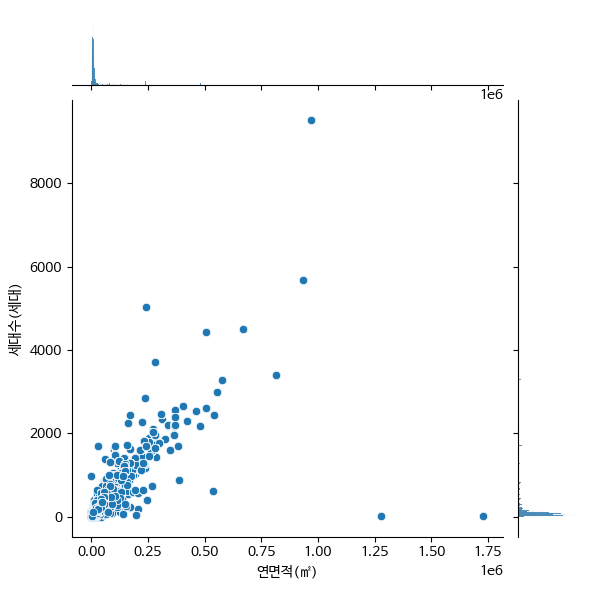

In [60]:
sns.jointplot(data=df_train[df_train['연면적(㎡)'] < 1e7 * 0.8], x='연면적(㎡)', y='세대수(세대)')

In [10]:
from sklearn.linear_model import LinearRegression

# 연면적과 세대수가 있는 부분으로 모델 학습
df = df_train[df_train['연면적(㎡)'] < 1e7 * 0.8]
train_data = df.dropna(subset=['연면적(㎡)', '세대수(세대)'])
X_train = train_data[['연면적(㎡)']]
y_train = train_data['세대수(세대)']

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# # 결측치가 있는 부분의 전용면적을 사용하여 건축면적 예측
missing_data = df[df['세대수(세대)'].isnull()]
X_missing = missing_data[['연면적(㎡)']]
predicted_values = model.predict(X_missing)

# # 결측치 채우기
df_train.loc[df_train['세대수(세대)'].isnull(), '세대수(세대)'] = predicted_values

In [11]:
df_train['세대수(세대)'].isna().sum()

0

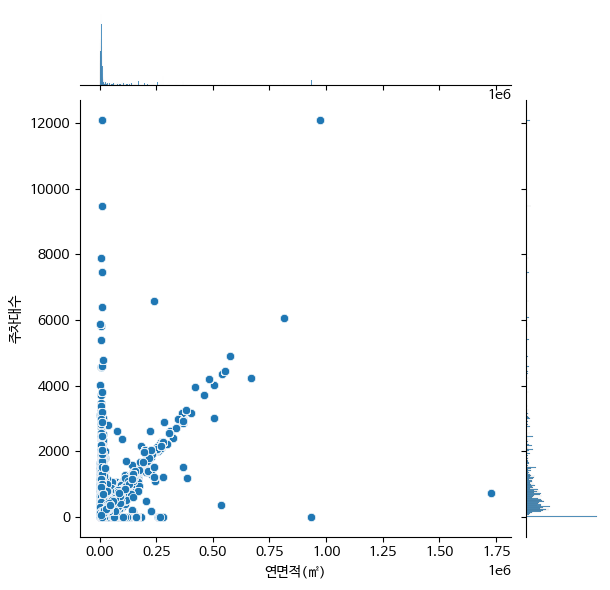

In [16]:
sns.jointplot(data=df_train[df_train['연면적(㎡)'] < 1e7 * 0.8], x='연면적(㎡)', y='주차대수')

In [21]:
from sklearn.tree import DecisionTreeRegressor

# 연면적과 세대수가 있는 부분으로 모델 학습
df = df_train[(df_train['연면적(㎡)'] < 1e7 * 0.8)]
train_data = df.dropna(subset=['연면적(㎡)', '주차대수'])
X_train = train_data[['연면적(㎡)']]
y_train = train_data['주차대수']

# 선형 회귀 모델 학습
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# # 결측치가 있는 부분의 전용면적을 사용하여 건축면적 예측
missing_data = df_train[df_train['주차대수'].isnull()]
X_missing = missing_data[['연면적(㎡)']]
predicted_values = model.predict(X_missing)

# # 결측치 채우기
df_train.loc[df_train['주차대수'].isnull(), '주차대수'] = predicted_values

In [22]:
predicted_values.min(), predicted_values.mean(), predicted_values.max()

(0.0, 513.4405519836862, 12096.0)

In [19]:
df_train['주차대수'].describe()

count    860997.000000
mean       1106.213392
std        1513.410502
min           0.000000
25%         315.000000
50%         652.000000
75%        1247.000000
max       12096.000000
Name: 주차대수, dtype: float64

In [23]:
df_train.isna().sum().sort_values(ascending=False)[25:45]

k-관리비부과면적              869561
k-관리방식                 869561
기타/의무/임대/임의=1/2/3/4    869561
k-난방방식                 869561
k-세대타입(분양형태)           869561
번지                        225
부번                         75
본번                         75
target                      0
건축면적(㎡)                     0
좌표Y                         0
좌표X                         0
주소                          0
도로명주소                       0
시군                          0
시군구                         0
연면적(㎡)                      0
k-건설사(시공사)                  0
세대수(세대)                     0
중개사소재지                      0
dtype: int64

In [24]:
df_train.to_csv('../new_train3.csv', index=False)